#       EE417 TERM-PROJECT REPORT
# ROAD SEGMENTATION USING U-NET ARCHITECTURE

## 1. Introduction

This project relates to the problem of road segmentation using Cambridge Video (CamVid) Dataset and one proposed solution for this task which utilizes the neural network architecture called U-Net. 

### 1.1 Problem Definition

Segmentation, in other words reorganization, is one of the main problems of computer vision which is the process of labeling each of the image pixels so that each of these labels will identify the boundaries of the objects on that image. More specifically, we have an image in our hand which has a background and several objects on it. The aim of segmentation problem is to label each of the pixels in that image in a way that the different objects in the image and background will be indicated pixel by pixel. Figure below illustrates the segmentation problem with an input output pair.

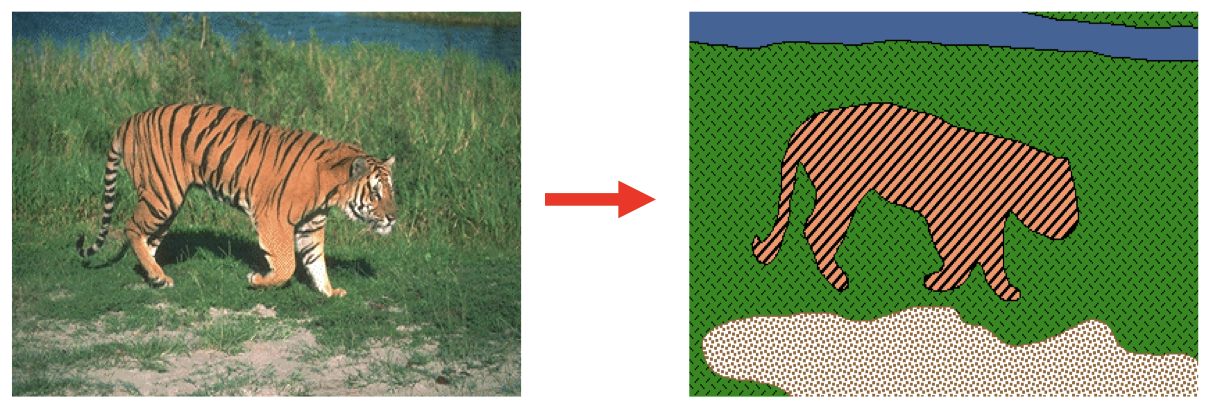

Road segmentation is a sub-problem of segmentation problem in which the given input image is an RGB image in a running traffic and it has the general objects in the traffic such as road, pedestrians, roadside objects etc. The aim of the road segmentation problem is to segment each of these traffic elements and indicate their boundaries in a rigorous manner. Below figure shows an example input-output pair.

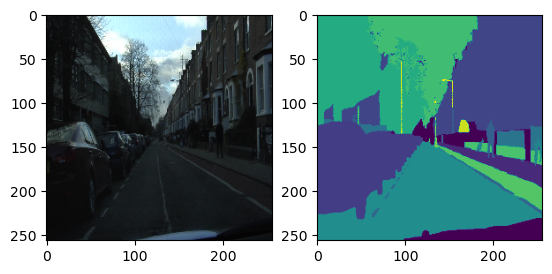

### 1.2 Problem Importance

The segmentation problem in general is a very important problem in computer vision. This is due to the fact that it extracts the object of the interest from the whole image and helps with bigger problems to be solved in an easier manner. Let us think about the medical image processing as an example. Some illnesses such as pneumoconiosis can be detected by applying CNN architectures on a lung X-Ray image. However, giving the whole X-Ray image to the model results in less accuracy due to the fact that some parts of the lung is far more important for the detection of this illness whereas some parts are of no importance at all. The idea is simple, extract those parts of the lung so that we get rid of more noise which results in better accuracy. A big portion of computer vision applications might improve with such a scenario by the help of the segmentation problem which makes our segmentation problem an important one.

The road segmentation problem is an important problem for  driving assistance systems as well as autonomous driving systems. The main reason is that some of the objects are of bigger importance whereas some of them are less important. In traffic for example, the pedestrians and other cars of extreme importance since those are the ones who takes the decisions whereas the roadside objects are of lower importance. Image segmentation problem enables us to make the distinction between different objects in the image thus returning more accurate results. As an example, the images segmented can be input of a detection model so that the objects are more effectively recognized. Thus, the road segmentation task, if handled carefully, can bring about better feature extraction results for other problems of computer vision.

## 2. Problem Formulation 

The scope of this problem includes taking an RGB input road image and returning a corresponding pixel-wise labeling of that input image. The bottleneck In this problem is identifying  which label each of the pixel corresponds and what are the boundaries of each object which makes our problem at the hand a complex problem. The aim of this project is to develop such a system that will allow us to segment different road objects with a good pixel accuracy and mIoU metric. 

## 3. Solution Method

There are many solutions proposed for the problem of road segmentation. One of such methods which is based on neural networks is the architecture called U-Net. U-Net is a general solution for segmentation problems which takes its name from the visual representation of the model which is illustrated in the Figure below.

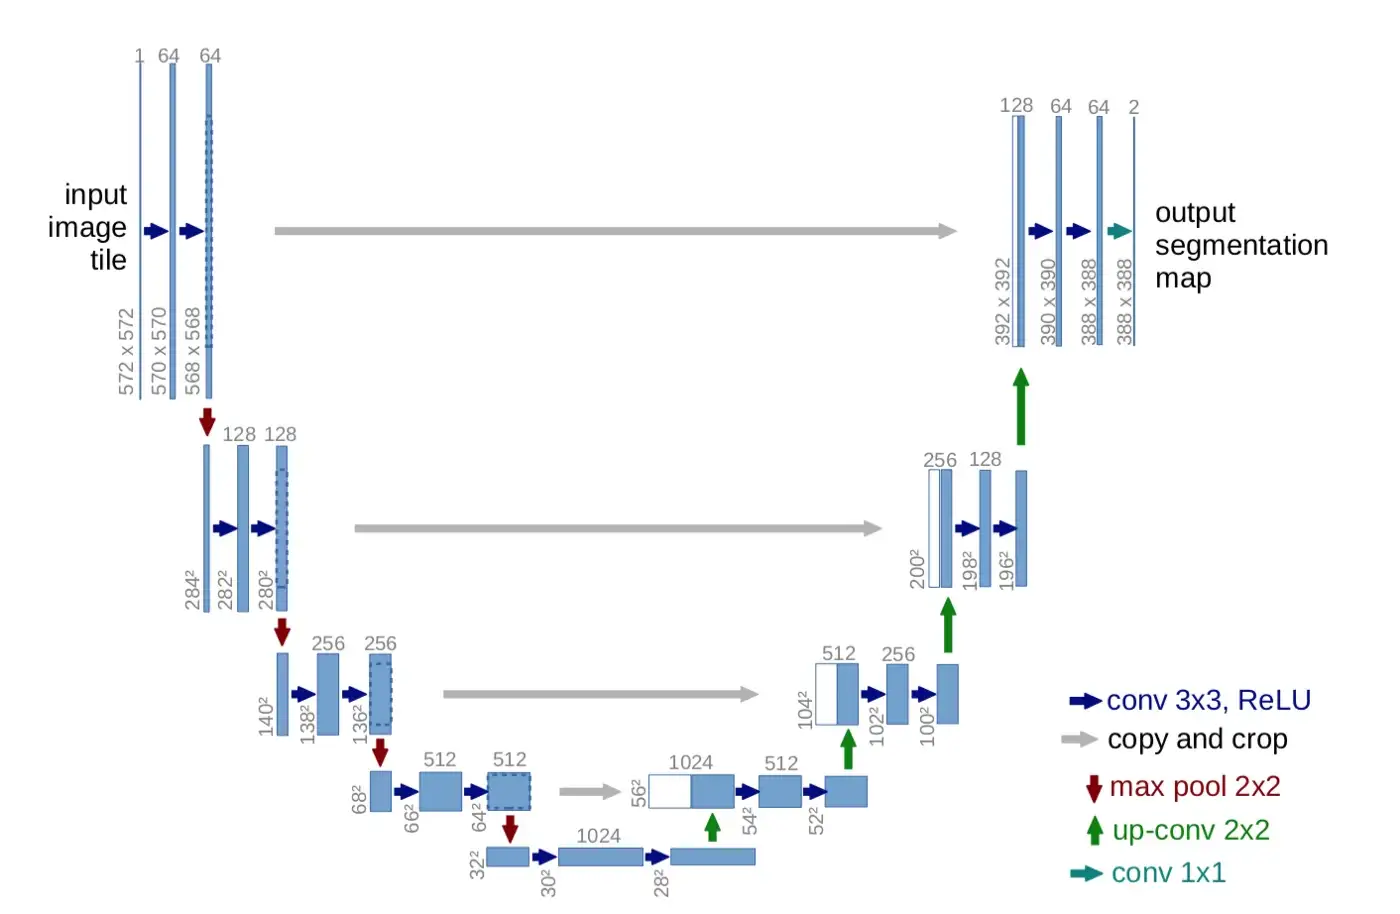

There are different building blocks of this model which are convolution layers, max pooling layers and up-convolution layers. The convolution layers and max pooling layers together form what we know as down block. The down blocks stands for encoding the information in the images into a smaller in frame size but bigger in the number format. These encoded information will then be used in the up block which can be considered as the decoding layer. When considered this way, U-Nets are much like autoencoders.

The down blocks, also called the contractive paths, are the repeating convolution layers which follows a max pooling layer of shape (2, 2). The use of down blocks repeated several times in  our implementation. The aside figure stands for representing the down blocks.

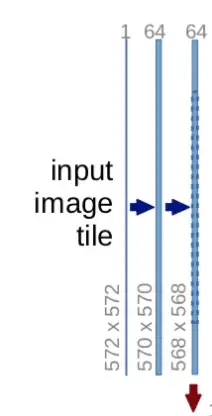

At the bottom of the model there are two convolution layers without any max pooling. Thus, these blocks are not also down blocks or up blocks, only convolutions to further extract features from the encoded images. Below is the demonstration of these layers.

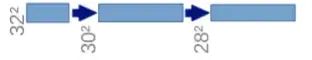

The up blocks, also called expansive path, first applies transposed convolution to the output it obtained from the contractive path. It then concatenates the transposed convolution layer output with the output of the the down block at the same level to use the information coming from the decoder. This process is illustrated in the Figure 1 as the long horizontal gray line. After concatenating these images we then apply double convolutions as we did for the down block. We repeat this procedure several times again and finally we apply the softmax activation to finalize the pixel-wise multiclass classification, namely segmentation. The concatenation and the up blocks are represented in the below figure.

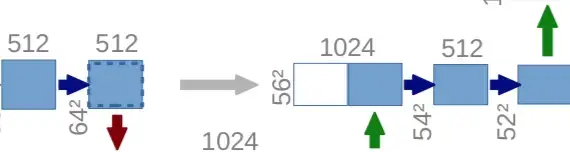

## 4. Implementation

In [1]:
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from typing import Tuple, List

2023-01-20 14:31:29.449926: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-20 14:31:29.585015: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-20 14:31:29.589380: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/yesilyurt/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-01-20 14:

In [2]:
from abc import ABC, abstractmethod
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Layer,
    Activation,
    BatchNormalization,
    Conv2D,
    MaxPooling2D,
)

from tensorflow.keras.layers import (
    Conv2DTranspose,
    Concatenate,
    Conv2D,
    Input,
)

from tensorflow.keras.metrics import BinaryAccuracy, MeanIoU, CategoricalAccuracy
from tensorflow.keras.metrics import binary_accuracy, categorical_accuracy

In [26]:
train = {'img' : [],
           'mask' : []
          }

val = {'img' : [],
           'mask' : []
          }

# Defining the data loader
def LoadData(dataset = None, imgPath = None, maskPath = None, shape = 256):
    imgNames = os.listdir(imgPath)
    maskNames = []
    
    ## generating mask names
    for mem in imgNames:
        maskNames.append(re.sub('\.png', '_L.png', mem))
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    for i in range (len(imgNames)):
        img = plt.imread(imgAddr + imgNames[i])
        mask = plt.imread(maskAddr + maskNames[i])
        
        img = cv2.resize(img, (shape, shape)) 
        mask = cv2.resize(mask, (shape, shape))
        
        dataset['img'].append(img)
        dataset['mask'].append(mask)
        
    return dataset

In [27]:
train_dataset = LoadData( train, imgPath = 'datasets/CamVid/train', maskPath = 'datasets/CamVid/train_labels', shape = 256)

In [28]:
val_dataset  = LoadData( val, imgPath = 'datasets/CamVid/val', maskPath = 'datasets/CamVid/val_labels', shape = 256)

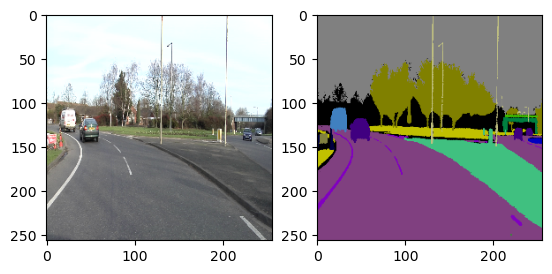

In [9]:
plt.subplot(1,2,1)
plt.imshow(train_dataset['img'][1])
plt.subplot(1,2,2)
plt.imshow(train_dataset['mask'][1])
plt.show()

### 4.1.1 Data Module

In [1]:
from tf_seg.data import get_camvid_data_loader

2023-02-11 17:13:36.730319: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-11 17:13:36.907708: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-11 17:13:36.911590: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-11 17:13:36.911612: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
from tf_seg.data.dataset import CamvidDataset, get_camvid

In [3]:
camvid = get_camvid()

TypeError: descriptor '__init__' of 'super' object needs an argument

In [10]:
class ModelBuilder(ABC):
    """Model builder abstract class. It is inherited by all the model builders."""
    tf_seg_type = "model_builder"
    @abstractmethod
    def build_model(self) -> Model:
        """Builds the model.

        Returns
        -------
        Model : tf.keras.model.Model
            The model.

        """
        pass

    def __str__(self):

        return f"model builder class for : {self.__class__.__name__}"

    def __repr__(self):

        return f"model builder class for : {self.__class__.__name__}"

In [11]:
class Unet(ModelBuilder):
    """
    Model builder for Vanialla UNet Model 
    """  
    def __init__(
        self,
        output_size: int,
        name: str = "unet",
        input_shape: Tuple = (512, 512, 3),
        n_filters: List[int] = [16, 32, 64, 128, 256],
        activation: str = "relu",
        final_activation: str = "sigmoid",
        backbone: str = None,
        pretrained: str = "imagenet",
    ) -> None:
        """Unet constructor."""

        self.input_shape = input_shape
        self.final_activation = final_activation
        self.n_filters = n_filters
        self.activation_name = activation
        self.backbone = backbone
        self.pretrained = pretrained
        self.name = name
        self.output_size = output_size

    def build_model(self) -> Model:
        """Builds the model.

        Returns
        -------
        Model : tf.keras.model.Model
            The model.

        """

        n_filters = self.n_filters

        if self.backbone is not None:
            if len(n_filters) >= 7:
                raise ValueError("If select backbone, n_filters must be lesser than 7")

            elif len(n_filters) < 3:
                raise ValueError("If select backbone, n_filters must be greater than 2")
            else:
                pass

        encoder_output = self._build_encoder()
        inputs = encoder_output[0]
        bridge = encoder_output[-1]
        connection_list = encoder_output[1:-1][::-1]
        decoder_n_filters = n_filters[:-1][::-1]

        # Decoder
        d = bridge
        for n, c in enumerate(connection_list):
            d = Conv2DTranspose(decoder_n_filters[n], (3, 3), padding="same", strides=(2, 2))(d)
            d = Concatenate()([d, c])
            d = ConvBlock(
                decoder_n_filters[n],
                self.activation_name,
                name=f"decode_{decoder_n_filters[n]}",
            )(d, pool=False)

        # if connection count is lesser decoder filter count , we make convolution without concatenation
        depth = len(connection_list)
        if len(decoder_n_filters) > depth:
            n_remain_block = len(decoder_n_filters) - depth
            remain_decoder_n_filter = decoder_n_filters[(-1 * n_remain_block) :]
            for fltr in remain_decoder_n_filter:
                d = Conv2DTranspose(fltr, (3, 3), padding="same", strides=(2, 2))(d)
                d = ConvBlock(fltr, self.activation_name, name=f"decode_{fltr}")(d, pool=False)

        # output
        outputs = Conv2D(self.output_size, (1, 1), activation=self.final_activation)(d)
        # Model
        model = Model(inputs, outputs, name=self.name)

        return model

    def _build_encoder(self):

        inputs = Input(self.input_shape, name="input")
        c0 = inputs

        if self.backbone is None:
            n_filters = self.n_filters
            connection_list = []
            p = c0
            for fltr in n_filters[:-1]:
                # c, p = self._conv_block(p, fltr)
                c, p = ConvBlock(fltr, self.activation_name, name="conv_block_{}".format(fltr))(p)
                connection_list.append(c)

            # Bridge
            b1 = ConvBlock(
                n_filters[-1],
                self.activation_name,
                name="bridge_1_{}".format(n_filters[-1]),
            )(p, pool=False)
            b2 = ConvBlock(
                n_filters[-1],
                self.activation_name,
                name="bridge_2_{}".format(n_filters[-1]),
            )(b1, pool=False)

            return [c0, *connection_list, b2]

        else:
            backbone_ = get_backbone(self.backbone, self.pretrained, inputs, depth=len(self.n_filters) - 1)

            return [
                c0,
                *backbone_(c0),
            ] 

In [12]:
class ConvBlock(Layer):
    """Convolutional Block for Unet and Variants"""

    def __init__(self, n_filter: int, activation: str, name: str = None):
        super(ConvBlock, self).__init__(name=name)
        self.n_filter = n_filter
        self.activation = activation
        self.layer_name = name

        self.conv1 = Conv2D(n_filter, (3, 3), padding="same")
        self.bn1 = BatchNormalization()
        self.act1 = Activation(activation)

        self.conv2 = Conv2D(n_filter, (3, 3), padding="same")
        self.bn2 = BatchNormalization()
        self.act2 = Activation(activation)

        self.pool = MaxPooling2D((2, 2), (2, 2))

    def call(self, x, pool=True, training=None):

        x = self.conv1(x)
        x = self.bn1(x, training=training)
        x = self.act1(x)

        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.act2(x)
        c = x

        if pool == True:
            x = self.pool(x)
            return c, x
        return c

    def get_config(self):
        config = super(ConvBlock, self).get_config()
        config.update({"n_filter": self.n_filter, "activation": self.activation})
        return config


In [13]:
unet = Unet(output_size=3, input_shape=(256,256,3))

In [14]:
model = unet.build_model()

2023-01-20 10:05:55.818412: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-20 10:05:55.818720: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/yesilyurt/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-01-20 10:05:55.818771: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/yesilyurt/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-01-20 10:05:55.818806: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could 

In [49]:
model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [50]:
history = model.fit(np.array(train_dataset['img']), np.array(train_dataset['mask']), epochs = 75, verbose = 0)

In [54]:
np.array(val_dataset['img'])[0].shape

(256, 256, 3)

## 5. Results

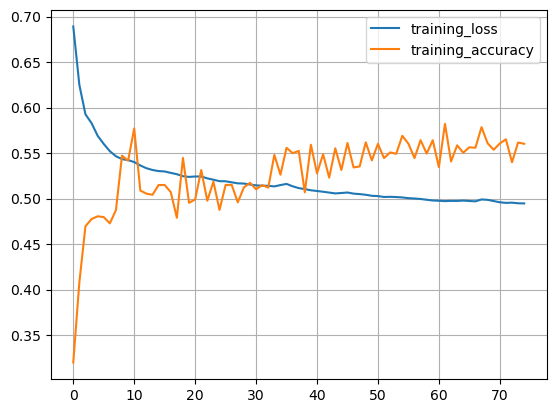

In [68]:
plt.plot(history.history['loss'], label = 'training_loss')
plt.plot(history.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

In [50]:
def predict_and_plot(val, i, model, shape = 256):
    ## getting and proccessing val data
    img = val['img'][i:i+1]
    mask = val['mask']
    mask = mask[i:i+1]
    imgProc = img[i:i+1]
    imgProc = np.array(img)
    predictions = model.predict(imgProc)

    pred = cv2.merge((predictions[0,:,:,0],predictions[0,:,:,1],predictions[0,:,:,2]))
    
    plt.figure(figsize=(11,11))

    plt.subplot(1,3,1)
    plt.imshow(img[0])
    plt.title('Input Image')
    
    plt.subplot(1,3,2)
    plt.imshow(pred)
    plt.title('Prediction')
    
    plt.subplot(1,3,3)
    plt.imshow(mask[0])
    plt.title('Ground Truth')    

1/1 [==============================] - 0s 57ms/step


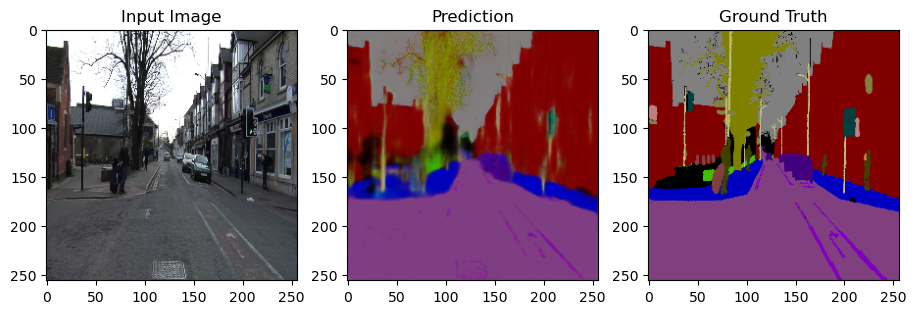

In [51]:
predict_and_plot(val_dataset, 0, model)

1/1 [==============================] - 0s 61ms/step


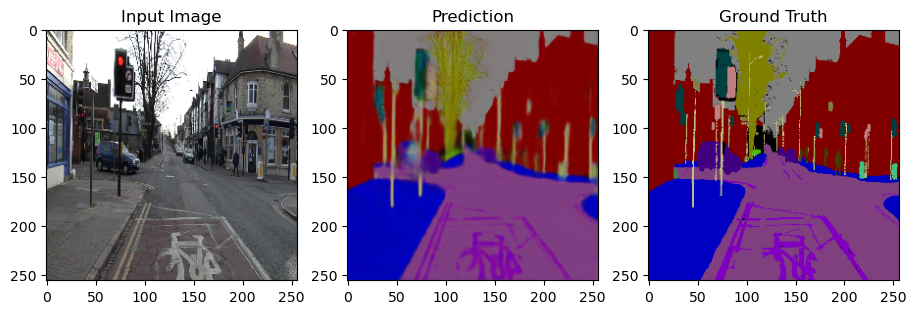

In [53]:
predict_and_plot(val_dataset, 11, model)

1/1 [==============================] - 0s 63ms/step


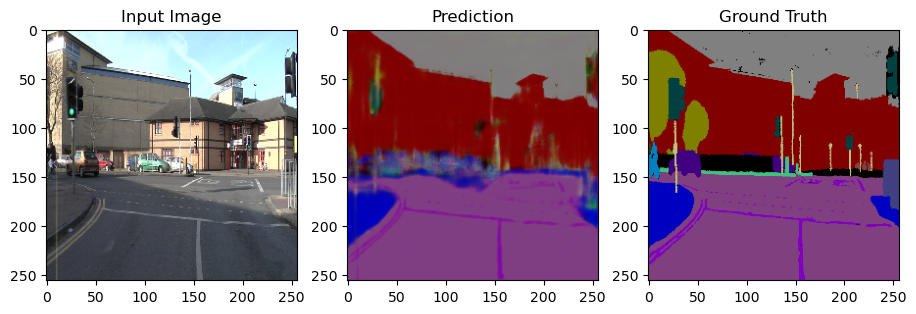

In [54]:
predict_and_plot(val_dataset, 22, model)

1/1 [==============================] - 0s 62ms/step


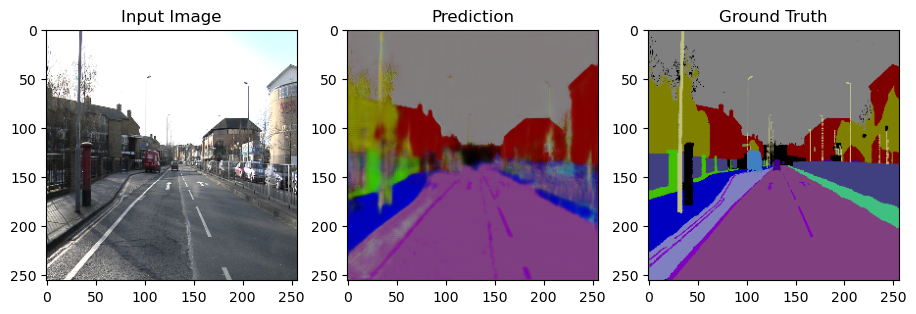

In [55]:
predict_and_plot(val_dataset, 33, model)

1/1 [==============================] - 0s 65ms/step


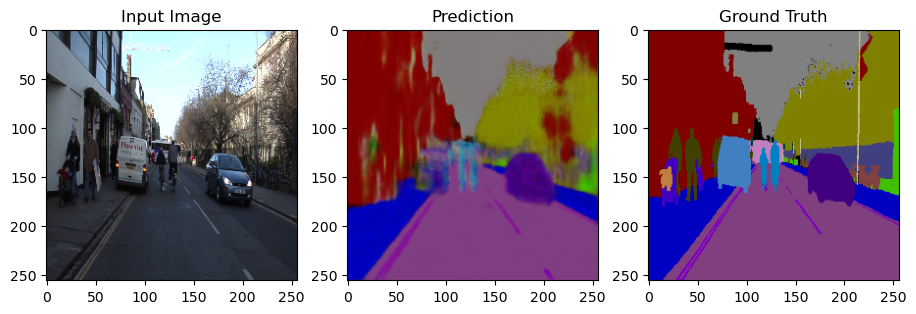

In [56]:
predict_and_plot(val_dataset, 44, model)

1/1 [==============================] - 0s 58ms/step


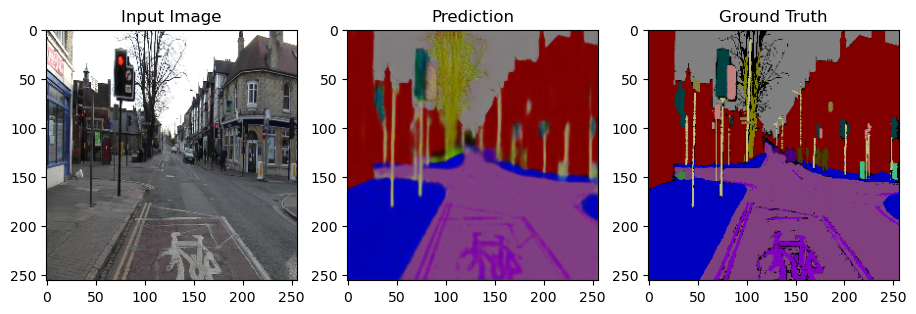

In [57]:
predict_and_plot(val_dataset, 55, model)

1/1 [==============================] - 0s 59ms/step


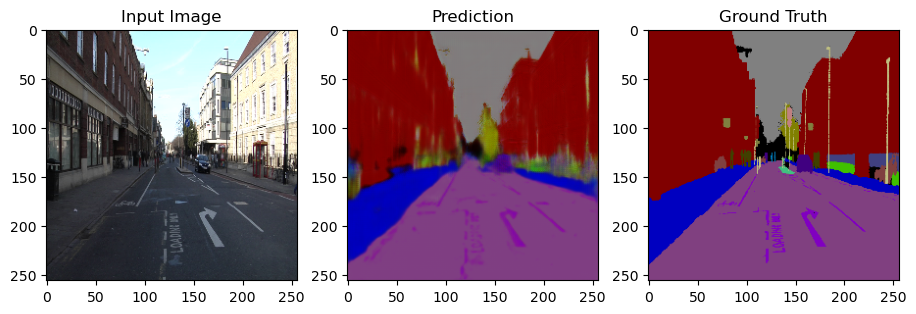

In [58]:
predict_and_plot(val_dataset, 66, model)

1/1 [==============================] - 0s 59ms/step


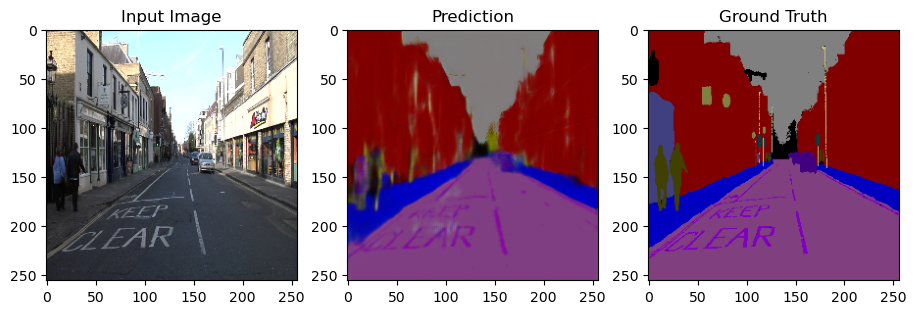

In [59]:
predict_and_plot(val_dataset, 77, model)

1/1 [==============================] - 0s 64ms/step


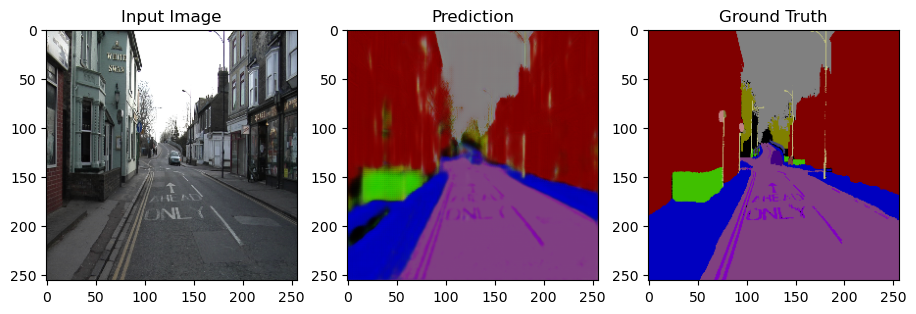

In [60]:
predict_and_plot(val_dataset, 88, model)

1/1 [==============================] - 0s 57ms/step


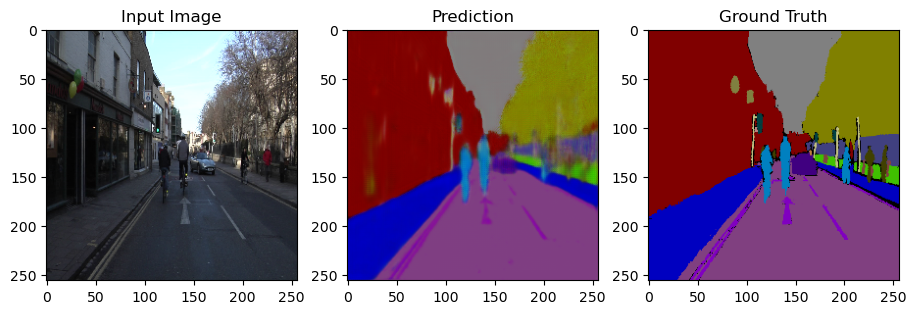

In [61]:
predict_and_plot(val_dataset, 99, model)

In [29]:
acc = tf.keras.metrics.Accuracy()

In [30]:
miou = MeanIoU(num_classes=32, dtype=tf.float64, axis=-1)

In [31]:
preds = tf.cast(model.predict(np.array(val_dataset["img"])), tf.float64)
preds = tf.math.argmax(preds, axis=-1)
gt = tf.constant(val_dataset["mask"], dtype = tf.float64)
gt = tf.math.argmax(gt, axis=-1)

4/4 [==============================] - 4s 907ms/step


In [32]:
print("Mean Intersection over Union on Test Dataset:", miou(gt, preds).numpy())

Mean Intersection over Union on Test Dataset: 0.3284865558039178


In [33]:
print("Accuracy on Test Dataset: ",acc(gt, preds).numpy())

Accuracy on Test Dataset:  0.6100507


## Discussion

The results above indicate that we succesfully built and trained a U-Net model for the task of Road Segmentation. Comparing between the predicted masks and the ground truth, one can easily prove that the generated model returns the expected output after 75th epochs of training on the CamVid dataset with batch_size = 1.

Looking at the history graph of the training process, we can see that training the model for 75 epochs is more than enough for this model, loss and optimizer setting since both the training loss and training accuracy has almost converged. 

The accuracy on test dataset is 0.61 which is not bad whereas the mean intersection over union is 0.32. Both of these values indicate that the results are good but not so significantly. The reason for the results being worse than expected might be caused by the utilization cross entropy as the loss function. The use of dice loss for this task of road segmentation could add more determinism to the model.

## References

https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5

https://arxiv.org/abs/1505.04597